In [137]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [138]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

## Image to Tensor Conversions

In [287]:
imsize = 256

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [424]:
set_folder = "Set10"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [425]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [298]:
device = torch.device("cuda")
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [263]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [264]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [265]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [266]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [273]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

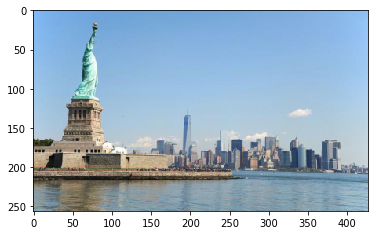

In [439]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [440]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.01)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

Iteration 1:  Style Loss = 0.000025  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000025  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000025  Content Loss = 0.000641 
Iteration 1:  Style Loss = 0.000024  Content Loss = 0.003013 
Iteration 1:  Style Loss = 0.000024  Content Loss = 0.005170 
Iteration 1:  Style Loss = 0.000023  Content Loss = 0.007028 
Iteration 1:  Style Loss = 0.000023  Content Loss = 0.009727 
Iteration 1:  Style Loss = 0.000022  Content Loss = 0.013485 
Iteration 1:  Style Loss = 0.000022  Content Loss = 0.017715 
Iteration 1:  Style Loss = 0.000021  Content Loss = 0.021337 
Iteration 1:  Style Loss = 0.000021  Content Loss = 0.024355 
Iteration 1:  Style Loss = 0.000020  Content Loss = 0.026923 
Iteration 1:  Style Loss = 0.000020  Content Loss = 0.029367 
Iteration 1:  Style Loss = 0.000019  Content Loss = 0.031750 
Iteration 1:  Style Loss = 0.000019  Content Loss = 0.034102 
Iteration 1:  Style Loss = 0.000019  Content Loss = 0.036484 
Iteratio

Iteration 7:  Style Loss = 0.000001  Content Loss = 0.217638 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.218232 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.218824 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.219398 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.219964 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.220520 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.221061 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.221592 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.222112 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.222624 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.223128 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.223617 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.224097 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.224565 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.225023 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.225478 
Iteratio

Iteration 14:  Style Loss = 0.000000  Content Loss = 0.247576 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.247641 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.247706 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.247772 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.247835 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.247898 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.247962 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.248024 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.248087 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.248148 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.248210 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.248271 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.248331 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.248389 
Iteration 15:  Style Loss = 0.000000  Content Loss = 0.248449 
Iteration 15:  Style Loss = 0.000000  Content Loss = 0.

Iteration 20:  Style Loss = 0.000000  Content Loss = 0.252087 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.252082 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252078 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252073 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252067 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252061 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252055 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252048 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252040 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252033 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252024 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252015 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.252005 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.251996 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.251986 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.

Iteration 27:  Style Loss = 0.000000  Content Loss = 0.249015 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248981 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248950 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248917 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248884 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248853 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248821 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248789 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248755 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.248723 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.248691 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.248659 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.248628 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.248593 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.248563 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 34:  Style Loss = 0.000000  Content Loss = 0.246110 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.246093 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.246077 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.246060 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.246043 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.246028 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.246011 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245994 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245976 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245958 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245942 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245926 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245909 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245891 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.245873 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.

Iteration 40:  Style Loss = 0.000000  Content Loss = 0.242433 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.242391 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.242349 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.242305 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.242258 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.242212 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.242168 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.242124 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.242083 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.242041 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.241995 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.241948 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.241903 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.241858 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.241812 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.

Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235837 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235785 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235732 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235680 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235625 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235574 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235522 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235468 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235417 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235364 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235308 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235256 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235205 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.235157 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.235102 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.

Iteration 53:  Style Loss = 0.000000  Content Loss = 0.229564 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.229525 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229489 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229457 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229421 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229385 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229348 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229310 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229277 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229243 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229210 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229176 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229143 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229109 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.229075 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226342 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226325 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226308 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226292 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226276 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226260 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226244 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226227 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226210 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.226194 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.226177 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.226161 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.226146 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.226129 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.226113 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.

Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224489 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224476 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224464 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224451 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224439 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224426 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224414 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224402 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224390 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224378 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224366 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224354 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224342 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224330 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.224318 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.

Iteration 73:  Style Loss = 0.000000  Content Loss = 0.222737 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.222723 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.222708 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.222693 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.222679 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.222664 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222649 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222634 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222620 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222605 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222590 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222574 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222559 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222545 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.222530 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.

Iteration 80:  Style Loss = 0.000000  Content Loss = 0.221061 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.221051 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.221042 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.221032 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.221023 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.221014 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.221004 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.220995 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.220985 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.220977 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.220968 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.220959 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.220950 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.220942 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.220933 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.

Iteration 86:  Style Loss = 0.000000  Content Loss = 0.220209 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.220204 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220200 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220195 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220191 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220186 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220182 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220177 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220173 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220168 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220164 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220160 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220155 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220151 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.220147 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219748 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219746 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219744 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219741 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219739 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219736 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219733 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219731 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219728 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.219726 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.219723 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.219721 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.219718 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.219716 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.219714 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.

Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219391 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219387 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219384 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219381 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219377 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219374 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219371 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219367 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219364 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219361 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219357 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219353 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219350 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219347 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.219343 
Iteration 100:  Style Loss = 0.000000  C

Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218893 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218889 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218885 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218881 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218877 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218873 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218869 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.218865 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.218860 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.218857 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.218852 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.218848 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.218844 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.218840 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.218836 
Iteration 107:  Style Loss = 0.000000  C

Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218495 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218493 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218491 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218490 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218488 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218486 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218485 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218483 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218481 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218480 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218478 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218477 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218475 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218474 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.218472 
Iteration 113:  Style Loss = 0.000000  C

Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218394 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218394 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218394 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218394 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218394 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218394 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218394 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.218393 
Iteration 120:  Style Loss = 0.000000  C

Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218417 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218417 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218417 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218417 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218418 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218418 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218418 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218418 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218418 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218419 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218419 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218419 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218419 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218420 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.218420 
Iteration 126:  Style Loss = 0.000000  C

Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218406 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218405 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218405 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218404 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218403 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218403 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218402 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.218401 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.218401 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.218400 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.218399 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.218399 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.218398 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.218397 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.218397 
Iteration 133:  Style Loss = 0.000000  C

Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218266 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218264 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218263 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218261 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218260 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218259 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218257 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218256 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218254 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218253 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218251 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218250 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218248 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218247 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.218245 
Iteration 139:  Style Loss = 0.000000  C

Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218076 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218074 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218073 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218072 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218070 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218069 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218068 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.218067 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.218065 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.218064 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.218063 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.218061 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.218060 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.218059 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.218058 
Iteration 146:  Style Loss = 0.000000  C

Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217955 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217955 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217954 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217954 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217954 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217953 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217953 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217952 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217952 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217952 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217951 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217951 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217951 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217950 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.217950 
Iteration 152:  Style Loss = 0.000000  C

Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217959 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217960 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217960 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217960 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217961 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217961 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217962 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.217962 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.217962 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.217963 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.217963 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.217964 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.217964 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.217965 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.217965 
Iteration 159:  Style Loss = 0.000000  C

Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218020 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218020 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218020 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218021 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218021 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218021 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218022 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218022 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218023 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218023 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218023 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218024 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218024 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218024 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.218024 
Iteration 165:  Style Loss = 0.000000  C

Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217999 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217998 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217997 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217996 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217995 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217994 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217993 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.217992 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.217991 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.217990 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.217989 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.217988 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.217987 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.217986 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.217985 
Iteration 172:  Style Loss = 0.000000  C

Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217750 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217747 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217744 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217741 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217738 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217736 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217733 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217729 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217727 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217724 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217721 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217718 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217715 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217712 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.217708 
Iteration 178:  Style Loss = 0.000000  C

Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217581 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217584 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217588 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217592 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217596 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217600 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217604 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.217609 
Iteration 186:  Style Loss = 0.000000  Content Loss = 0.217609 
Iteration 186:  Style Loss = 0.000000  Content Loss = 0.217613 
Iteration 186:  Style Loss = 0.000000  Content Loss = 0.217618 
Iteration 186:  Style Loss = 0.000000  Content Loss = 0.217622 
Iteration 186:  Style Loss = 0.000000  Content Loss = 0.217626 
Iteration 186:  Style Loss = 0.000000  Content Loss = 0.217631 
Iteration 186:  Style Loss = 0.000000  Content Loss = 0.217636 
Iteration 186:  Style Loss = 0.000000  C

Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218069 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218067 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218064 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218062 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218059 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218057 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218054 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218051 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218048 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218045 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218042 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218039 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218036 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218032 
Iteration 192:  Style Loss = 0.000000  Content Loss = 0.218028 
Iteration 192:  Style Loss = 0.000000  C

Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217495 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217492 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217489 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217487 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217485 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217483 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217481 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.217479 
Iteration 199:  Style Loss = 0.000000  Content Loss = 0.217477 
Iteration 199:  Style Loss = 0.000000  Content Loss = 0.217475 
Iteration 199:  Style Loss = 0.000000  Content Loss = 0.217473 
Iteration 199:  Style Loss = 0.000000  Content Loss = 0.217470 
Iteration 199:  Style Loss = 0.000000  Content Loss = 0.217468 
Iteration 199:  Style Loss = 0.000000  Content Loss = 0.217467 
Iteration 199:  Style Loss = 0.000000  Content Loss = 0.217465 
Iteration 199:  Style Loss = 0.000000  C

Iteration 205:  Style Loss = 0.000000  Content Loss = 0.217348 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217346 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217343 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217340 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217338 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217336 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217334 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217331 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217328 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217326 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217323 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217321 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217318 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217315 
Iteration 206:  Style Loss = 0.000000  Content Loss = 0.217312 
Iteration 206:  Style Loss = 0.000000  C

Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216644 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216636 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216629 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216622 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216615 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216607 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216600 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216593 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216586 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216579 
Iteration 212:  Style Loss = 0.000000  Content Loss = 0.216572 
Iteration 213:  Style Loss = 0.000000  Content Loss = 0.216563 
Iteration 213:  Style Loss = 0.000000  Content Loss = 0.216555 
Iteration 213:  Style Loss = 0.000000  Content Loss = 0.216548 
Iteration 213:  Style Loss = 0.000000  Content Loss = 0.216540 
Iteration 213:  Style Loss = 0.000000  C

Iteration 218:  Style Loss = 0.000000  Content Loss = 0.215884 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215880 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215876 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215872 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215868 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215864 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215860 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215855 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215851 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215848 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215843 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215839 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215835 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215831 
Iteration 219:  Style Loss = 0.000000  Content Loss = 0.215827 
Iteration 219:  Style Loss = 0.000000  C

Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215257 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215252 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215246 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215241 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215235 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215229 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215223 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215218 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215212 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215206 
Iteration 225:  Style Loss = 0.000000  Content Loss = 0.215199 
Iteration 226:  Style Loss = 0.000000  Content Loss = 0.215193 
Iteration 226:  Style Loss = 0.000000  Content Loss = 0.215187 
Iteration 226:  Style Loss = 0.000000  Content Loss = 0.215180 
Iteration 226:  Style Loss = 0.000000  Content Loss = 0.215174 
Iteration 226:  Style Loss = 0.000000  C

Iteration 231:  Style Loss = 0.000000  Content Loss = 0.214215 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214205 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214195 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214184 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214175 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214164 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214155 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214146 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214137 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214127 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214118 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214108 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214099 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214089 
Iteration 232:  Style Loss = 0.000000  Content Loss = 0.214079 
Iteration 232:  Style Loss = 0.000000  C

Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213060 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213053 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213046 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213038 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213031 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213024 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213017 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213010 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.213002 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.212995 
Iteration 238:  Style Loss = 0.000000  Content Loss = 0.212989 
Iteration 239:  Style Loss = 0.000000  Content Loss = 0.212983 
Iteration 239:  Style Loss = 0.000000  Content Loss = 0.212976 
Iteration 239:  Style Loss = 0.000000  Content Loss = 0.212969 
Iteration 239:  Style Loss = 0.000000  Content Loss = 0.212962 
Iteration 239:  Style Loss = 0.000000  C

Iteration 244:  Style Loss = 0.000000  Content Loss = 0.212291 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212285 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212280 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212275 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212270 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212265 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212260 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212254 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212249 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212244 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212239 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212234 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212228 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212222 
Iteration 245:  Style Loss = 0.000000  Content Loss = 0.212217 
Iteration 245:  Style Loss = 0.000000  C

Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211615 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211610 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211605 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211600 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211595 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211590 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211584 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211579 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211574 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211570 
Iteration 251:  Style Loss = 0.000000  Content Loss = 0.211565 
Iteration 252:  Style Loss = 0.000000  Content Loss = 0.211559 
Iteration 252:  Style Loss = 0.000000  Content Loss = 0.211554 
Iteration 252:  Style Loss = 0.000000  Content Loss = 0.211550 
Iteration 252:  Style Loss = 0.000000  Content Loss = 0.211545 
Iteration 252:  Style Loss = 0.000000  C

Iteration 257:  Style Loss = 0.000000  Content Loss = 0.211003 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210999 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210995 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210990 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210986 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210982 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210978 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210974 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210970 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210966 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210962 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210958 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210954 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210950 
Iteration 258:  Style Loss = 0.000000  Content Loss = 0.210946 
Iteration 258:  Style Loss = 0.000000  C

Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210582 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210580 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210578 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210575 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210573 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210570 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210568 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210566 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210563 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210561 
Iteration 264:  Style Loss = 0.000000  Content Loss = 0.210559 
Iteration 265:  Style Loss = 0.000000  Content Loss = 0.210556 
Iteration 265:  Style Loss = 0.000000  Content Loss = 0.210554 
Iteration 265:  Style Loss = 0.000000  Content Loss = 0.210552 
Iteration 265:  Style Loss = 0.000000  Content Loss = 0.210550 
Iteration 265:  Style Loss = 0.000000  C

Iteration 270:  Style Loss = 0.000000  Content Loss = 0.210368 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210367 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210366 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210365 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210364 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210363 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210362 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210361 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210360 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210359 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210358 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210357 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210356 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210355 
Iteration 271:  Style Loss = 0.000000  Content Loss = 0.210354 
Iteration 271:  Style Loss = 0.000000  C

Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210290 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210289 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210289 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210289 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210289 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210288 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210288 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210288 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210287 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210287 
Iteration 277:  Style Loss = 0.000000  Content Loss = 0.210287 
Iteration 278:  Style Loss = 0.000000  Content Loss = 0.210287 
Iteration 278:  Style Loss = 0.000000  Content Loss = 0.210286 
Iteration 278:  Style Loss = 0.000000  Content Loss = 0.210286 
Iteration 278:  Style Loss = 0.000000  Content Loss = 0.210286 
Iteration 278:  Style Loss = 0.000000  C

Iteration 283:  Style Loss = 0.000000  Content Loss = 0.210263 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210263 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210263 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210262 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210262 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210262 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210262 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210261 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210261 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210261 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210261 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210261 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210260 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210260 
Iteration 284:  Style Loss = 0.000000  Content Loss = 0.210260 
Iteration 284:  Style Loss = 0.000000  C

Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210229 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210229 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210228 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210228 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210227 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210227 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210227 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210226 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210226 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210226 
Iteration 290:  Style Loss = 0.000000  Content Loss = 0.210225 
Iteration 291:  Style Loss = 0.000000  Content Loss = 0.210225 
Iteration 291:  Style Loss = 0.000000  Content Loss = 0.210224 
Iteration 291:  Style Loss = 0.000000  Content Loss = 0.210224 
Iteration 291:  Style Loss = 0.000000  Content Loss = 0.210224 
Iteration 291:  Style Loss = 0.000000  C

Iteration 296:  Style Loss = 0.000000  Content Loss = 0.210168 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210168 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210167 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210167 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210166 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210166 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210165 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210165 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210164 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210163 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210163 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210162 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210162 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210161 
Iteration 297:  Style Loss = 0.000000  Content Loss = 0.210161 
Iteration 297:  Style Loss = 0.000000  C

Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210100 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210100 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210100 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210099 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210099 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210098 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210098 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210097 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210097 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210097 
Iteration 303:  Style Loss = 0.000000  Content Loss = 0.210096 
Iteration 304:  Style Loss = 0.000000  Content Loss = 0.210096 
Iteration 304:  Style Loss = 0.000000  Content Loss = 0.210095 
Iteration 304:  Style Loss = 0.000000  Content Loss = 0.210095 
Iteration 304:  Style Loss = 0.000000  Content Loss = 0.210094 
Iteration 304:  Style Loss = 0.000000  C

Iteration 309:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  Content Loss = 0.210068 
Iteration 310:  Style Loss = 0.000000  C

Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 316:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 317:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 317:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 317:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 317:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 317:  Style Loss = 0.000000  C

Iteration 322:  Style Loss = 0.000000  Content Loss = 0.210060 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210060 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210060 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210060 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210059 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210059 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210059 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210059 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210058 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210058 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210058 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210058 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210057 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210057 
Iteration 323:  Style Loss = 0.000000  Content Loss = 0.210057 
Iteration 323:  Style Loss = 0.000000  C

Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210023 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210022 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210022 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210022 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210022 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210021 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210021 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210021 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210021 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210020 
Iteration 329:  Style Loss = 0.000000  Content Loss = 0.210020 
Iteration 330:  Style Loss = 0.000000  Content Loss = 0.210020 
Iteration 330:  Style Loss = 0.000000  Content Loss = 0.210019 
Iteration 330:  Style Loss = 0.000000  Content Loss = 0.210019 
Iteration 330:  Style Loss = 0.000000  Content Loss = 0.210019 
Iteration 330:  Style Loss = 0.000000  C

Iteration 335:  Style Loss = 0.000000  Content Loss = 0.209988 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209987 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209987 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209987 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209986 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209986 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209986 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209985 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209985 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209985 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209985 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209984 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209984 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209984 
Iteration 336:  Style Loss = 0.000000  Content Loss = 0.209983 
Iteration 336:  Style Loss = 0.000000  C

Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209948 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209947 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209947 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209947 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209946 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209946 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209946 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209945 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209945 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209945 
Iteration 342:  Style Loss = 0.000000  Content Loss = 0.209944 
Iteration 343:  Style Loss = 0.000000  Content Loss = 0.209944 
Iteration 343:  Style Loss = 0.000000  Content Loss = 0.209944 
Iteration 343:  Style Loss = 0.000000  Content Loss = 0.209944 
Iteration 343:  Style Loss = 0.000000  Content Loss = 0.209943 
Iteration 343:  Style Loss = 0.000000  C

Iteration 355:  Style Loss = 0.000000  Content Loss = 0.209922 
Iteration 355:  Style Loss = 0.000000  Content Loss = 0.209922 
Iteration 355:  Style Loss = 0.000000  Content Loss = 0.209922 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209922 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209922 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209923 
Iteration 356:  Style Loss = 0.000000  Content Loss = 0.209924 
Iteration 356:  Style Loss = 0.000000  C

Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210062 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210064 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210066 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210069 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210071 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210073 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210075 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210077 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210080 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210082 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210084 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210086 
Iteration 362:  Style Loss = 0.000000  Content Loss = 0.210088 
Iteration 363:  Style Loss = 0.000000  Content Loss = 0.210090 
Iteration 363:  Style Loss = 0.000000  Content Loss = 0.210092 
Iteration 363:  Style Loss = 0.000000  C

Iteration 368:  Style Loss = 0.000000  Content Loss = 0.210162 
Iteration 368:  Style Loss = 0.000000  Content Loss = 0.210162 
Iteration 368:  Style Loss = 0.000000  Content Loss = 0.210161 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210161 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210160 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210159 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210159 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210158 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210157 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210157 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210156 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210156 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210155 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210155 
Iteration 369:  Style Loss = 0.000000  Content Loss = 0.210154 
Iteration 369:  Style Loss = 0.000000  C

Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210119 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210120 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210120 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210120 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 375:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 376:  Style Loss = 0.000000  Content Loss = 0.210121 
Iteration 376:  Style Loss = 0.000000  Content Loss = 0.210122 
Iteration 376:  Style Loss = 0.000000  C

Iteration 381:  Style Loss = 0.000000  Content Loss = 0.210217 
Iteration 381:  Style Loss = 0.000000  Content Loss = 0.210218 
Iteration 381:  Style Loss = 0.000000  Content Loss = 0.210219 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210220 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210221 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210223 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210224 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210225 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210227 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210228 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210229 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210231 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210232 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210233 
Iteration 382:  Style Loss = 0.000000  Content Loss = 0.210234 
Iteration 382:  Style Loss = 0.000000  C

Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210555 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210559 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210562 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210566 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210570 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210574 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210577 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210583 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210587 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210592 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210596 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210600 
Iteration 388:  Style Loss = 0.000000  Content Loss = 0.210604 
Iteration 389:  Style Loss = 0.000000  Content Loss = 0.210609 
Iteration 389:  Style Loss = 0.000000  Content Loss = 0.210613 
Iteration 389:  Style Loss = 0.000000  C

Iteration 394:  Style Loss = 0.000000  Content Loss = 0.210918 
Iteration 394:  Style Loss = 0.000000  Content Loss = 0.210919 
Iteration 394:  Style Loss = 0.000000  Content Loss = 0.210921 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210922 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210923 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210924 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210925 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210926 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210928 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210929 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210930 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210932 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210933 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210934 
Iteration 395:  Style Loss = 0.000000  Content Loss = 0.210935 
Iteration 395:  Style Loss = 0.000000  C

Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211127 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211129 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211131 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211133 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211135 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211136 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211139 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211140 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211142 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211144 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211145 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211148 
Iteration 401:  Style Loss = 0.000000  Content Loss = 0.211150 
Iteration 402:  Style Loss = 0.000000  Content Loss = 0.211152 
Iteration 402:  Style Loss = 0.000000  Content Loss = 0.211154 
Iteration 402:  Style Loss = 0.000000  C

Iteration 407:  Style Loss = 0.000000  Content Loss = 0.211546 
Iteration 407:  Style Loss = 0.000000  Content Loss = 0.211552 
Iteration 407:  Style Loss = 0.000000  Content Loss = 0.211558 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211564 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211571 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211577 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211582 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211589 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211595 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211601 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211606 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211613 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211620 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211626 
Iteration 408:  Style Loss = 0.000000  Content Loss = 0.211634 
Iteration 408:  Style Loss = 0.000000  C

Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212543 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212549 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212555 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212562 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212569 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212576 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212582 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212590 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212596 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212602 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212608 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212615 
Iteration 414:  Style Loss = 0.000000  Content Loss = 0.212622 
Iteration 415:  Style Loss = 0.000000  Content Loss = 0.212629 
Iteration 415:  Style Loss = 0.000000  Content Loss = 0.212636 
Iteration 415:  Style Loss = 0.000000  C

Iteration 420:  Style Loss = 0.000000  Content Loss = 0.213155 
Iteration 420:  Style Loss = 0.000000  Content Loss = 0.213157 
Iteration 420:  Style Loss = 0.000000  Content Loss = 0.213159 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213161 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213162 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213164 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213166 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213168 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213171 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213173 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213175 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213178 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213180 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213182 
Iteration 421:  Style Loss = 0.000000  Content Loss = 0.213185 
Iteration 421:  Style Loss = 0.000000  C

Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213548 
Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213554 
Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213559 
Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213563 
Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213568 
Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213573 
Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213577 
Iteration 427:  Style Loss = 0.000000  Content Loss = 0.213581 
Iteration 428:  Style Loss = 0.000000  Content Loss = 0.213585 
Iteration 428:  Style Loss = 0.000000  Content Loss = 0.213590 
Iteration 428:  Style Loss = 0.000000  Content Loss = 0.213595 
Iteration 428:  Style Loss = 0.000000  Content Loss = 0.213600 
Iteration 428:  Style Loss = 0.000000  Content Loss = 0.213604 
Iteration 428:  Style Loss = 0.000000  Content Loss = 0.213608 
Iteration 428:  Style Loss = 0.000000  Content Loss = 0.213612 
Iteration 428:  Style Loss = 0.000000  C

Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214500 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214507 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214515 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214524 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214534 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214542 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214550 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214558 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214569 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214575 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214582 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214588 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214600 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214609 
Iteration 434:  Style Loss = 0.000000  Content Loss = 0.214617 
Iteration 434:  Style Loss = 0.000000  C

Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215059 
Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215060 
Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215062 
Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215063 
Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215065 
Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215066 
Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215067 
Iteration 440:  Style Loss = 0.000000  Content Loss = 0.215068 
Iteration 441:  Style Loss = 0.000000  Content Loss = 0.215069 
Iteration 441:  Style Loss = 0.000000  Content Loss = 0.215071 
Iteration 441:  Style Loss = 0.000000  Content Loss = 0.215071 
Iteration 441:  Style Loss = 0.000000  Content Loss = 0.215072 
Iteration 441:  Style Loss = 0.000000  Content Loss = 0.215074 
Iteration 441:  Style Loss = 0.000000  Content Loss = 0.215076 
Iteration 441:  Style Loss = 0.000000  Content Loss = 0.215077 
Iteration 441:  Style Loss = 0.000000  C

Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214931 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214929 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214927 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214925 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214923 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214922 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214920 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214919 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214916 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214915 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214913 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214912 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214911 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214910 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.214910 
Iteration 448:  Style Loss = 0.000000  C

Iteration 454:  Style Loss = 0.000000  Content Loss = 0.214763 
Iteration 454:  Style Loss = 0.000000  Content Loss = 0.214762 
Iteration 454:  Style Loss = 0.000000  Content Loss = 0.214761 
Iteration 454:  Style Loss = 0.000000  Content Loss = 0.214760 
Iteration 454:  Style Loss = 0.000000  Content Loss = 0.214760 
Iteration 454:  Style Loss = 0.000000  Content Loss = 0.214759 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214758 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214756 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214754 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214752 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214750 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214749 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214747 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214745 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.214742 
Iteration 455:  Style Loss = 0.000000  C

Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214351 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214346 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214340 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214336 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214332 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214328 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214324 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214320 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214316 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214311 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214307 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214304 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214300 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214297 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.214293 
Iteration 461:  Style Loss = 0.000000  C

Iteration 467:  Style Loss = 0.000000  Content Loss = 0.213869 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.213865 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.213861 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.213857 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.213853 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.213848 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213844 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213840 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213836 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213831 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213827 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213823 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213818 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213814 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.213810 
Iteration 468:  Style Loss = 0.000000  C

Iteration 474:  Style Loss = 0.000000  Content Loss = 0.213015 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.213006 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212997 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212989 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212980 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212971 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212963 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212954 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212945 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212935 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212926 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212917 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212907 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212899 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.212889 
Iteration 474:  Style Loss = 0.000000  C

Iteration 480:  Style Loss = 0.000000  Content Loss = 0.211624 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.211613 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.211602 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.211591 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.211579 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.211569 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211559 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211548 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211538 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211527 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211516 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211505 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211495 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211485 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.211473 
Iteration 481:  Style Loss = 0.000000  C

Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210303 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210294 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210284 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210275 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210265 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210256 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210247 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210237 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210229 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210220 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210210 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210200 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210190 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210181 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.210171 
Iteration 487:  Style Loss = 0.000000  C

Iteration 493:  Style Loss = 0.000000  Content Loss = 0.209100 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.209091 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.209082 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.209074 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.209066 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.209058 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.209049 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.209041 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.209032 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.209022 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.209013 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.209005 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.208996 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.208988 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.208980 
Iteration 494:  Style Loss = 0.000000  C

Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208167 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208161 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208156 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208150 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208144 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208138 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208133 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208127 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208121 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208115 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208109 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208104 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208099 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208093 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.208087 
Iteration 500:  Style Loss = 0.000000  C

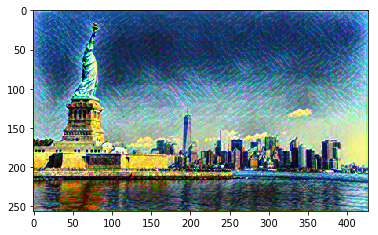

In [441]:
output = style_transfer(vgg, content, style, input_img, iters=500, style_w=100000000, content_w=100)
output.save("UpdatedSets/"+set_folder+"/output.png")